In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from src.Graph import SingleGeneGraph
from src.Function import read_spatial_expression
from src import Preprocess
from tqdm import tqdm
%matplotlib inline

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def spatial_plot(adata, color, map = 'bwr'):
    sc.set_figure_params(facecolor="white", figsize=(8, 8))
    ax=sc.pl.scatter(adata,alpha=1,x="array_row",y="array_col", color = color, 
                 title=color,show=False,size=500000/adata.shape[0],
                 color_map=map,frameon=False)
    ax.set_aspect('equal', 'box')
    # ax.axes.invert_yaxis()

In [3]:
kneighbors, beta = 4,2
dataDir = "../dataset/MOB-breast_cancer/Rep11_MOB_count_matrix-1.tsv"
locs, data, _ = read_spatial_expression(dataDir)
locsDf = pd.DataFrame(locs, columns=["imagerow", "imagecol"])
locsDf.index = data.index
adata = sc.AnnData(X=data, obs=locsDf)
adata = Preprocess.data_preprocess(adata, high_var=True)
new_index = ["array_row", "array_col"]
adata.obs.rename(
    columns={"imagerow": new_index[0], "imagecol": new_index[1]}, inplace=True
)


raw data dim: (262, 16218)
Number of expressed genes a spot must have to be kept (0.01% of total expressed genes) 3375
Marked 3 spots
Removing genes that are expressed in less than 3 spots with a count of at least 1
Dropped 1559 genes


/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:220: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  disp_grouped = df.groupby('mean_bin')['dispersions']
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [4]:
imputedExp = pd.DataFrame(index=adata.obs.index, columns=adata.var_names)
pbar = tqdm(adata.var_names)
for gene in pbar:
    graph = SingleGeneGraph(adata, gene, kneighbors, verbose=False)
    graph.mrf_with_icmem(beta=beta, icm_iter=3, max_iter=5)
    graph.impute(alpha=0.6, theta=0.2)
    imputedExp[gene] = graph.imputedExp
imputedExp.to_csv("imputedExp.csv")

  0%|          | 8/3319 [00:03<23:26,  2.35it/s]


KeyboardInterrupt: 

In [5]:
imputedExp = pd.read_csv("./output/MOB/imputedExp.csv", index_col=0)
adata_out = sc.AnnData(X=imputedExp, obs=adata.obs)

         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


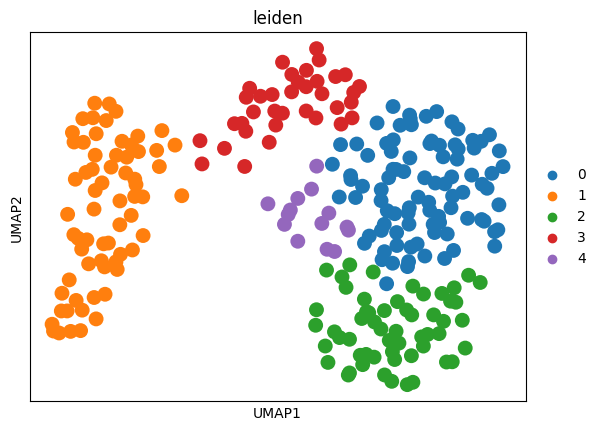

In [6]:
sc.pp.neighbors(adata_out, n_neighbors=10)
sc.tl.umap(adata_out)
sc.tl.leiden(adata_out, resolution=0.64)
sc.pl.umap(adata_out, color=['leiden'])

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


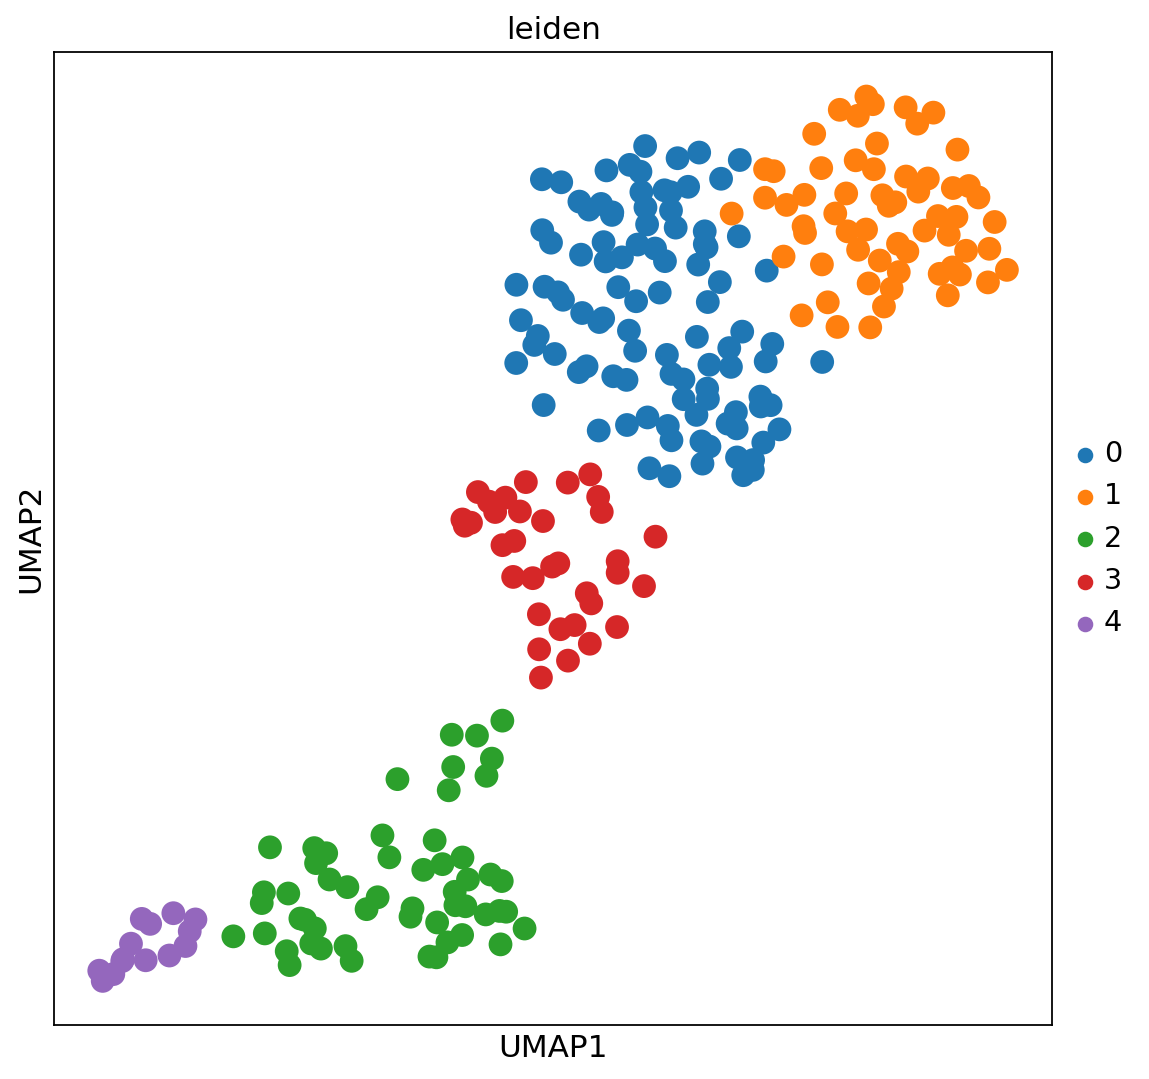

In [12]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.umap(adata)
sc.tl.leiden(adata, resolution=0.55)
sc.pl.umap(adata, color='leiden')

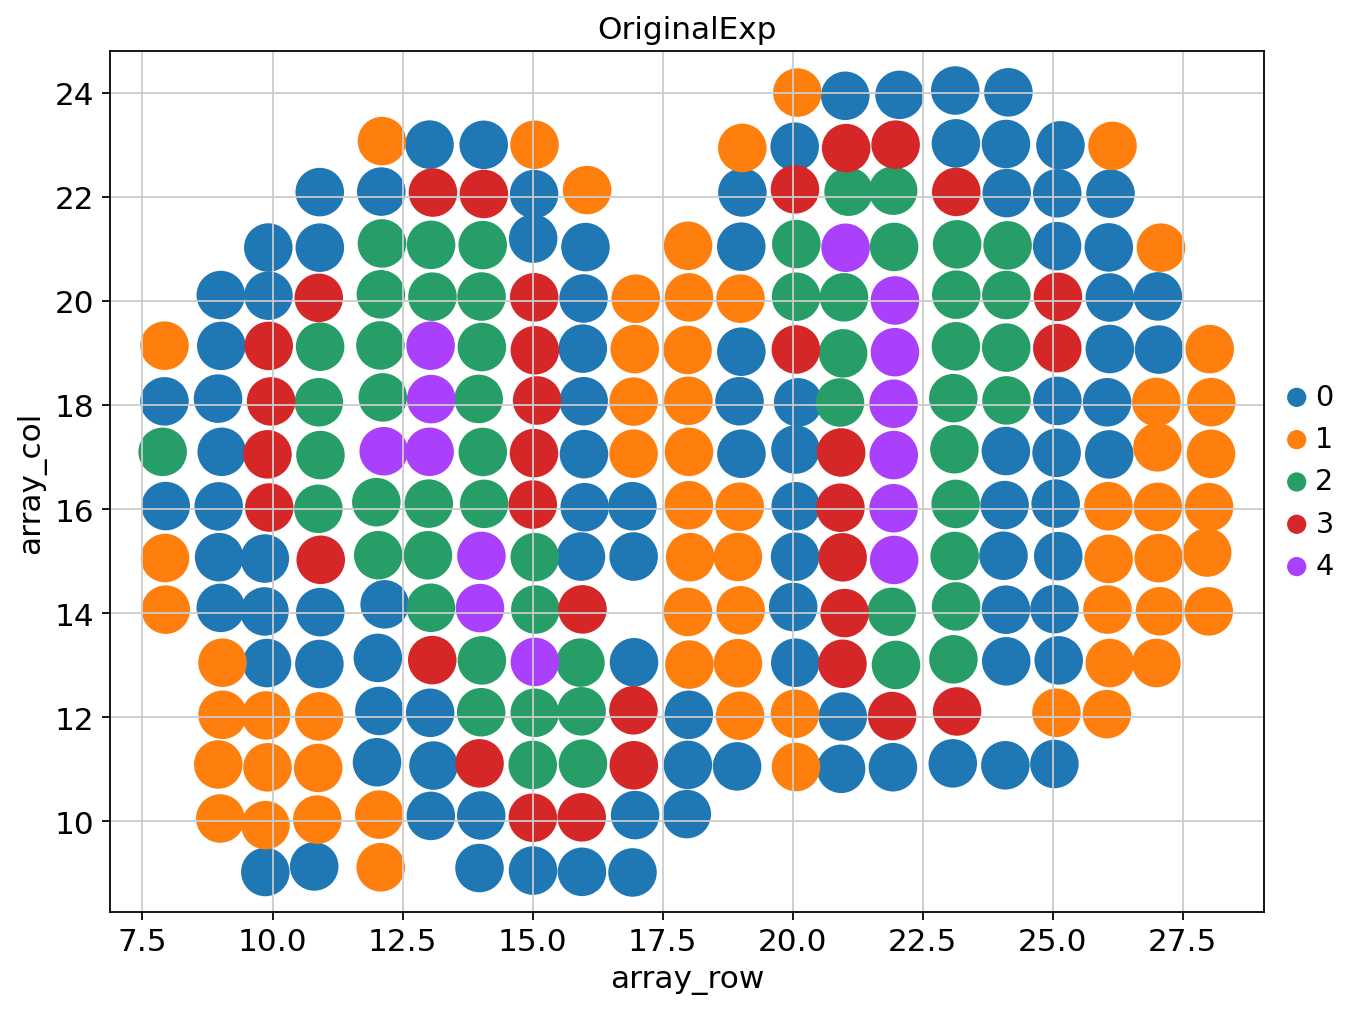

In [13]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
ax=sc.pl.scatter(adata,alpha=1,x="array_row",y="array_col", color = "leiden", 
                title="OriginalExp",show=False,size=500000/adata.shape[0],
                frameon=False)
ax.set_aspect('equal', 'box')

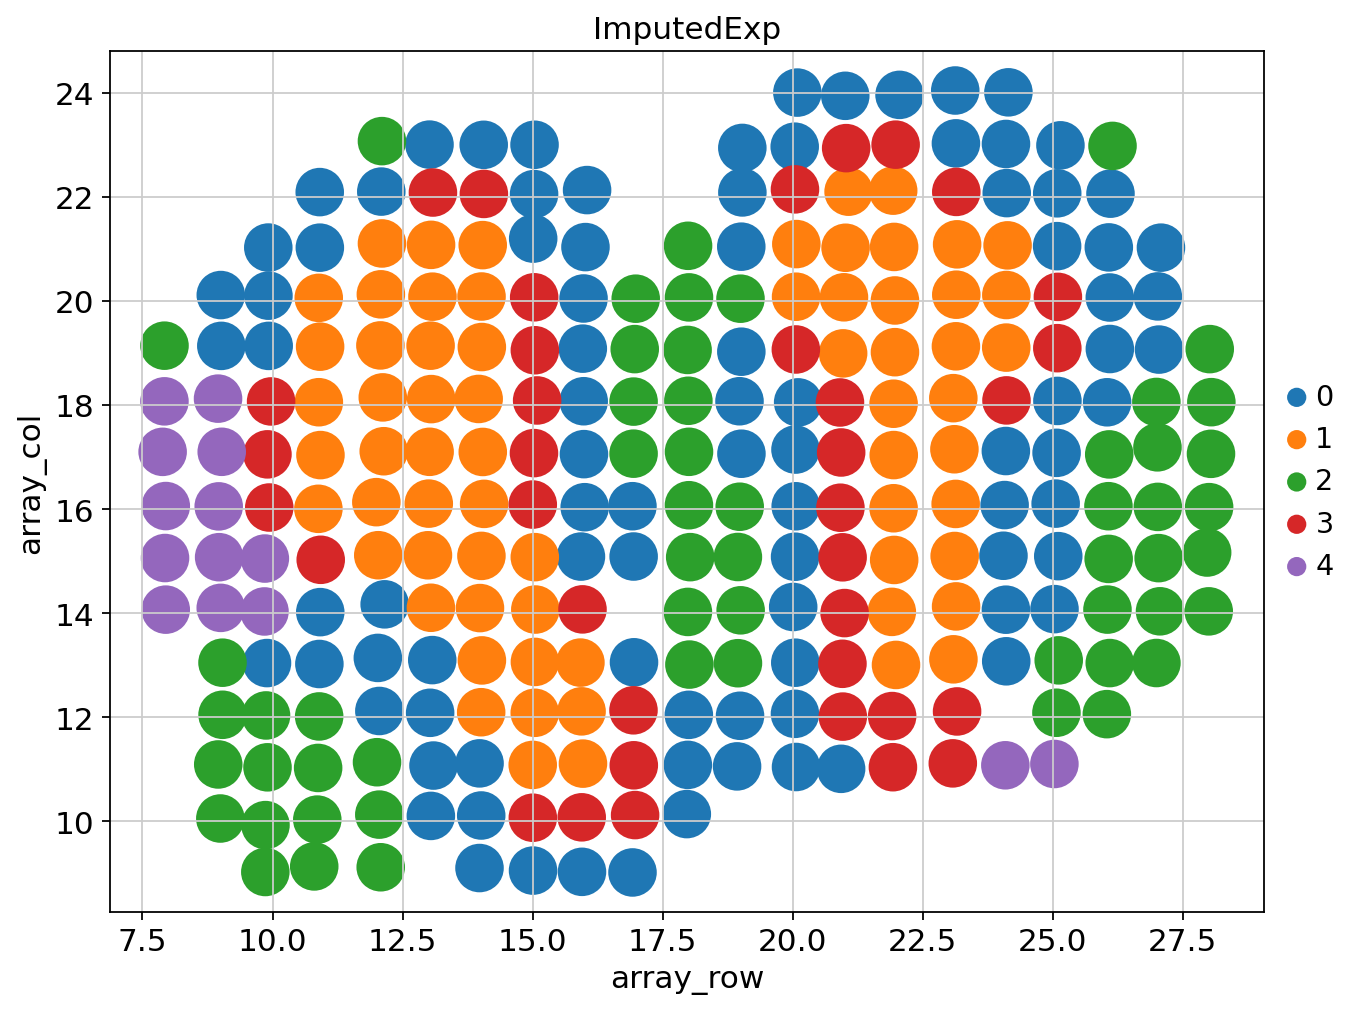

In [9]:
sc.set_figure_params(facecolor="white", figsize=(8, 8))
ax=sc.pl.scatter(adata_out,alpha=1,x="array_row",y="array_col", color = "leiden", 
                title="ImputedExp",show=False,size=500000/adata.shape[0],
                frameon=False)
ax.set_aspect('equal', 'box')

In [3]:
adata = sc.read_visium("../dataset/goldStandard")
adata.var_names_make_unique()

/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/home/qinxianhan/.conda/envs/sc/lib/python3.11/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
adata.shape 

(3639, 33538)

In [11]:
imputedExp = pd.DataFrame(index=adata.obs.index, columns=adata.var_names)

In [16]:
imputedExp['OR4F29'] = gene

In [17]:
imputedExp['OR4F29']

AAACAAGTATCTCCCA-1    1.0
AAACAATCTACTAGCA-1    1.0
AAACACCAATAACTGC-1    1.0
AAACAGAGCGACTCCT-1    1.0
AAACAGCTTTCAGAAG-1    1.0
                     ... 
TTGTTTCACATCCAGG-1    1.0
TTGTTTCATTAGTCTA-1    1.0
TTGTTTCCATACAACT-1    1.0
TTGTTTGTATTACACG-1    1.0
TTGTTTGTGTAAATTC-1    1.0
Name: OR4F29, Length: 3639, dtype: float64